In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir, getcwd, chdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import operator
import xgboost as xgb
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException
from xgboost.core import STRING_TYPES

import diff_predictor
from diff_predictor import data_process
from diff_predictor.predxgboost import train


/Users/nelsschimek/anaconda3/envs/diff_predictor_env/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/nelsschimek/anaconda3/envs/diff_predictor_env/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-

In [2]:
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '9c49afdd-cccb-44e2-a4eb-5b2f941c774c'
resource_group = 'schimek_cloud'
workspace_name = 'schimek_mpt_eastus2'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='enzyme_mpt_data_registered')
dataset.download(target_path='.', overwrite=True)

['/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_ChABC_brain_1_slice_1_vid_1.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_ChABC_brain_1_slice_2_vid_4.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_ChABC_brain_2_slice_1_vid_2.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_ChABC_brain_2_slice_2_vid_5.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_ChABC_brain_3_slice_1_vid_3.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_ChABC_brain_3_slice_3_vid_1.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_ChABC_brain_4_slice_1_vid_4.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_ChABC_brain_4_slice_3_vid_2.csv',
 '/Users

In [3]:
filelist = []
for file in dataset.to_path():
    filelist.append(file)
print('showing five path examples')
print(filelist[0:5])

showing five path examples
['/features_ChABC_brain_1_slice_1_vid_1.csv', '/features_ChABC_brain_1_slice_1_vid_2.csv', '/features_ChABC_brain_1_slice_1_vid_3.csv', '/features_ChABC_brain_1_slice_1_vid_4.csv', '/features_ChABC_brain_1_slice_1_vid_5.csv']


In [4]:
datasetpath = getcwd()


In [5]:
print('running generate_fullstats function on subset filelist')
fstats_tot = data_process.generate_fullstats(datasetpath, filelist, ['ChABC', 'NT'], 'treatment')
print(fstats_tot.head())

running generate_fullstats function on subset filelist
Adding file /features_ChABC_brain_1_slice_1_vid_1.csv size: (502, 67)
Adding file /features_ChABC_brain_1_slice_1_vid_2.csv size: (1734, 67)
Adding file /features_ChABC_brain_1_slice_1_vid_3.csv size: (593, 67)
Adding file /features_ChABC_brain_1_slice_1_vid_4.csv size: (258, 67)
Adding file /features_ChABC_brain_1_slice_1_vid_5.csv size: (888, 67)
Adding file /features_ChABC_brain_1_slice_2_vid_1.csv size: (1350, 67)
Adding file /features_ChABC_brain_1_slice_2_vid_2.csv size: (690, 67)
Adding file /features_ChABC_brain_1_slice_2_vid_3.csv size: (1257, 67)
Adding file /features_ChABC_brain_1_slice_2_vid_4.csv size: (1070, 67)
Adding file /features_ChABC_brain_1_slice_2_vid_5.csv size: (1097, 67)
Adding file /features_ChABC_brain_1_slice_3_vid_1.csv size: (1141, 67)
Adding file /features_ChABC_brain_1_slice_3_vid_2.csv size: (1307, 67)
Adding file /features_ChABC_brain_1_slice_3_vid_3.csv size: (650, 67)
Adding file /features_ChABC_

In [7]:
feature_list = [
  
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'treatment'

In [10]:
best_param = {'max_depth': 2, 'eta': 0.01, 'min_child_weight': 10, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 2, 'silent': 'True', 'gamma': 0.2, 'subsample': 0.6, 'colsample_bytree': 1.0, 'eval_metric': 'mlogloss'}


In [11]:
import random

random.seed(42)
print(random.randint(a=1, b=2000))
print(random.randint(a=1, b=2000))

1310
229


In [12]:
from tqdm import tqdm_notebook, tnrange


acc_list = []
true_label_list = []
preds_list = []
for i in tnrange(50, desc='1st loop'):
    #     sampled_filelist = []
#     class_lens = [0, 15, 30, 45, 60, 75] # this is specific to the age data set!
#     for i in range(len(class_lens)-1):
#         rand_integers = random.sample(set(np.arange(class_lens[i], class_lens[i+1])), 15)
#         for rand_int in rand_integers:
#             sampled_filelist.append(filelist[rand_int])
    fstats_tot = data_process.generate_fullstats(datasetpath, filelist, ['ChABC', 'NT'], 'treatment')
    ecm = fstats_tot[feature_list + [target, 'Track_ID', 'X', 'Y', 'frames']]
    ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)] 
    bal_ecm = data_process.balance_data(ecm, target)
    sampled_df = data_process.bin_data(bal_ecm)
    label_df = sampled_df['treatment']
    features_df = sampled_df.drop(['treatment', 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID', 'frames'], axis=1)
    features = features_df.columns

    random.seed(1234)
    seed = random.randint(a=1, b=2000)
    print(seed)
    
    train_split = 0.8
    test_split = 0.5

    le = preprocessing.LabelEncoder()
    sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

    training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

    X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
    X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    y_val = X_val['encoded_target']

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)
    dval = xgb.DMatrix(X_val[features], label=y_val)
    booster, acc, true_label, preds = train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=627)
    acc_list.append(acc)
    true_label_list.append(true_label)
    preds_list.append(preds)



Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


1st loop:   0%|          | 0/50 [00:00<?, ?it/s]

Adding file /features_ChABC_brain_1_slice_1_vid_1.csv size: (502, 67)
Adding file /features_ChABC_brain_1_slice_1_vid_2.csv size: (1734, 67)
Adding file /features_ChABC_brain_1_slice_1_vid_3.csv size: (593, 67)
Adding file /features_ChABC_brain_1_slice_1_vid_4.csv size: (258, 67)
Adding file /features_ChABC_brain_1_slice_1_vid_5.csv size: (888, 67)
Adding file /features_ChABC_brain_1_slice_2_vid_1.csv size: (1350, 67)
Adding file /features_ChABC_brain_1_slice_2_vid_2.csv size: (690, 67)
Adding file /features_ChABC_brain_1_slice_2_vid_3.csv size: (1257, 67)
Adding file /features_ChABC_brain_1_slice_2_vid_4.csv size: (1070, 67)
Adding file /features_ChABC_brain_1_slice_2_vid_5.csv size: (1097, 67)
Adding file /features_ChABC_brain_1_slice_3_vid_1.csv size: (1141, 67)
Adding file /features_ChABC_brain_1_slice_3_vid_2.csv size: (1307, 67)
Adding file /features_ChABC_brain_1_slice_3_vid_3.csv size: (650, 67)
Adding file /features_ChABC_brain_1_slice_3_vid_4.csv size: (1594, 67)
Adding file 

In [14]:
import os
output_dict = {'Accuracies': acc_list,
               'True Labels': true_label_list,
               'Preds': preds_list,
}
df = pd.DataFrame(output_dict)
# Save a sample of the data in the outputs folder (which gets uploaded automatically)
os.makedirs('outputs', exist_ok=True)
df.to_csv("outputs/run_data_enzyme.csv", index=False, header=True)

In [15]:
acc_list

[0.6976394169835235,
 0.6877972773495161,
 0.6874247652676351,
 0.6829113924050633,
 0.6681173436492586,
 0.6861969509682736,
 0.6816826496897413,
 0.696142244800762,
 0.6823089700996677,
 0.6943615257048092,
 0.6753887928906442,
 0.690328727965698,
 0.6851060462171573,
 0.6745063413067908,
 0.7039634146341464,
 0.673368412785675,
 0.6690937257939582,
 0.6737677855514503,
 0.6927332782824113,
 0.6927791309813782,
 0.6791975862350159,
 0.6908542394410924,
 0.6787415804172827,
 0.689515488482923,
 0.6765413658617542,
 0.6975045148579871,
 0.6992624315964787,
 0.6904096462508984,
 0.6733533663607569,
 0.6762298470442332,
 0.6726025159287699,
 0.6867218250461884,
 0.6882410264739321,
 0.679485129517109,
 0.6707674759654554,
 0.6931417044881493,
 0.6867287636334687,
 0.6681651681651681,
 0.6751720664764143,
 0.6801015550618851,
 0.6835106382978723,
 0.6853835249645613,
 0.6926844437534012,
 0.6951199871154775,
 0.678240364286876,
 0.6787421383647799,
 0.6835907034783965,
 0.6764418377321603

In [16]:
sorted_acc_list = sorted(acc_list)
sorted_acc_list[24:26]

[0.6835106382978723, 0.6835907034783965]

In [37]:
acc_np_array = np.array(acc_list)
acc_mean = np.mean(acc_np_array)
acc_std = np.std(acc_np_array)
print('mean accuracy: ' + str(acc_mean))
print('std accuracy: ' + str(acc_std))

mean accuracy: 0.6837984656571809
std accuracy: 0.008947456641107413


In [17]:
sorted_acc_list

[0.6681173436492586,
 0.6681651681651681,
 0.6690937257939582,
 0.6707674759654554,
 0.6726025159287699,
 0.6733533663607569,
 0.673368412785675,
 0.6737677855514503,
 0.6745063413067908,
 0.6751195009317021,
 0.6751720664764143,
 0.6753887928906442,
 0.6762298470442332,
 0.6764418377321603,
 0.6765413658617542,
 0.678240364286876,
 0.6787415804172827,
 0.6787421383647799,
 0.6791975862350159,
 0.679485129517109,
 0.6801015550618851,
 0.6816826496897413,
 0.6823089700996677,
 0.6829113924050633,
 0.6835106382978723,
 0.6835907034783965,
 0.6851060462171573,
 0.6853835249645613,
 0.6861969509682736,
 0.6867218250461884,
 0.6867287636334687,
 0.6874247652676351,
 0.6877972773495161,
 0.6882410264739321,
 0.689515488482923,
 0.690328727965698,
 0.6904096462508984,
 0.6908542394410924,
 0.6926844437534012,
 0.6927332782824113,
 0.6927346533013007,
 0.6927791309813782,
 0.6931417044881493,
 0.6943615257048092,
 0.6951199871154775,
 0.696142244800762,
 0.6975045148579871,
 0.6976394169835235

In [18]:
middle_val = acc_list.index(sorted_acc_list[24])
middle_val

40

In [23]:
acc_np_array = np.array(acc_list)
acc_mean = np.mean(acc_np_array)
acc_std = np.std(acc_np_array)
print('mean accuracy: ' + str(acc_mean))
print('std accuracy: ' + str(acc_std))

mean accuracy: 0.6837984656571809
std accuracy: 0.008947456641107413


In [20]:
print(classification_report(true_label_list[middle_val], preds_list[middle_val], target_names=['ChABC', 'NT']))

              precision    recall  f1-score   support

       ChABC       0.69      0.66      0.68      6148
          NT       0.68      0.70      0.69      6260

    accuracy                           0.68     12408
   macro avg       0.68      0.68      0.68     12408
weighted avg       0.68      0.68      0.68     12408



In [21]:
le.classes_

array(['ChABC', 'NT'], dtype=object)

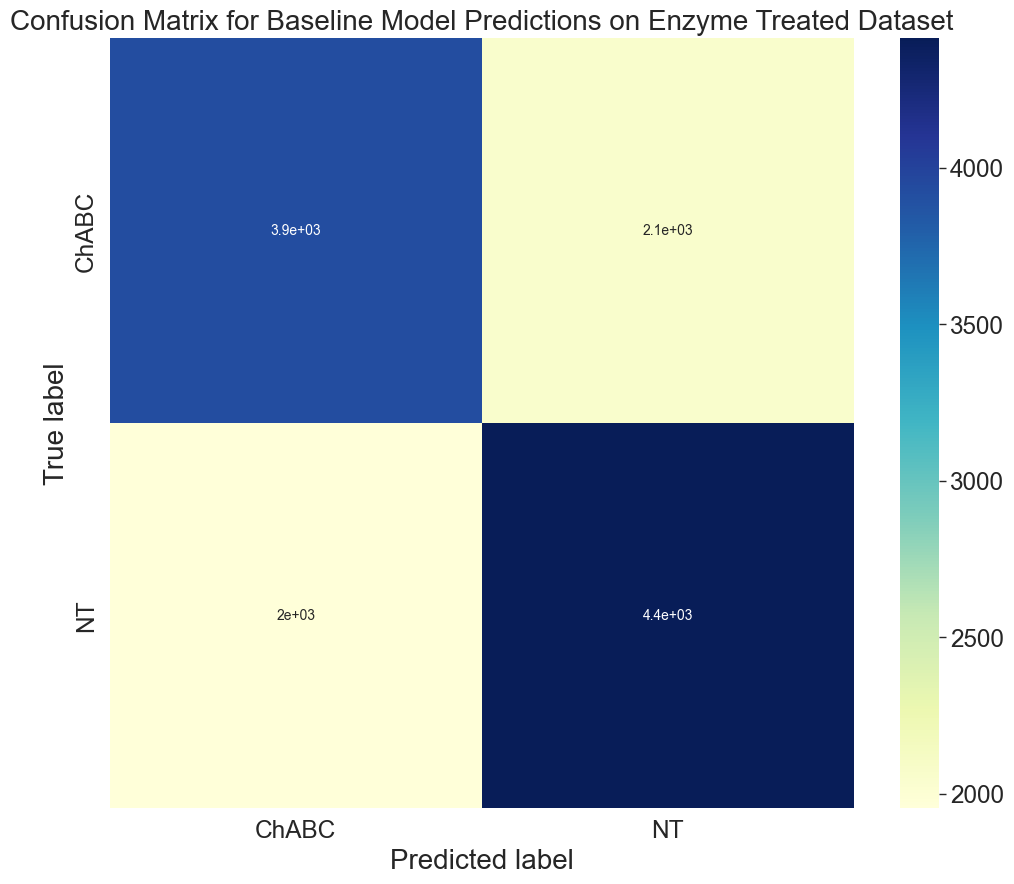

In [36]:
#make confusion matrix
import seaborn as sns

middle_val = i
class_names = le.classes_
metrics.confusion_matrix(true_label_list[middle_val], preds_list[middle_val])
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(true_label_list[middle_val], preds_list[middle_val])
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set_context("paper", font_scale=2) #font_scale=1.4)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="YlGnBu")

plt.ylabel('True label', fontsize=20)#, weight='bold')
plt.xlabel('Predicted label', fontsize=20)#, weight='bold')
plt.title('Confusion Matrix for Baseline Model Predictions on Enzyme Treated Dataset', fontsize=20)#, weight='bold')
plt.show()